In [1]:
# nsmc 텍스트 토큰나이징 한 pickle 데이터 불러오기
import pickle
with open('train_text.pk', 'rb') as f:
    train = pickle.load(f)
with open('test_text.pk', 'rb') as f:
    test = pickle.load(f)

In [2]:
len(train), len(test)

(146124, 48760)

In [3]:
# import
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# 파라미터
max_words = 35000
max_len = 50
batch_size=128
epochs = 30

In [5]:
# 데이터 전처리
# 토크나이징, 패딩(제로패딩)
import numpy as np

# 문서만 추출
train_x = [doc for doc, _ in train]

# 토크나이징
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_x)

# 변환(LSTM모델의 입력값을 넣기 위해)
x_train = tokenizer.texts_to_sequences(train_x)
y_train = np.array([int(label) for _, label in train])

x_test = tokenizer.texts_to_sequences([doc for doc, _ in test])
y_test = np.array([int(label) for _, label in test])

# 길이를 동일하게 맞추기
x_train = pad_sequences(x_train, maxlen=max_len, padding='pre')
x_test = pad_sequences(x_test, maxlen=max_len, padding='pre')

# 학습가능한 형태로 변환
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [6]:
train_ds

<BatchDataset shapes: ((None, 50), (None,)), types: (tf.int32, tf.int32)>

In [7]:
# 모델 구현
# 클래스로 구현하는 방법
class MyLSTM(tf.keras.Model):
    # 생성자
    def __init__(self):
        # 부모클래스의 생성자 호출
        super().__init__()
        self.emb = Embedding(max_words, 100)
        self.lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2)
        self.dense = Dense(1, activation='sigmoid')
    
    def call(self, x):
        x = self.emb(x)
        x = self.lstm(x)
        x = self.dense(x)
        return x

In [8]:
# 모델객체 선언
model = MyLSTM()

In [9]:
# 모델설정
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [10]:
# Early Stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, verbose=1)
# ModelCheckpoint
mc = tf.keras.callbacks.ModelCheckpoint('nsmc_bestmodel.cp', monitor='val_loss', mode='min', save_best_only=True)

In [11]:
# 학습
history = model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size, callbacks=[es, mc])

Epoch 1/30
1142/1142 [==============================] - 227s 196ms/step - loss: 0.4690 - acc: 0.7626 - val_loss: 0.3933 - val_acc: 0.8181
Epoch 2/30
1142/1142 [==============================] - 220s 193ms/step - loss: 0.3476 - acc: 0.8456 - val_loss: 0.3999 - val_acc: 0.8187
Epoch 3/30
1142/1142 [==============================] - 221s 194ms/step - loss: 0.2988 - acc: 0.8719 - val_loss: 0.4314 - val_acc: 0.8132
Epoch 4/30
1142/1142 [==============================] - 221s 194ms/step - loss: 0.2517 - acc: 0.8923 - val_loss: 0.4838 - val_acc: 0.8066
Epoch 00004: early stopping


In [12]:
model.evaluate(x_test, y_test)

1524/1524 [==============================] - 15s 10ms/step - loss: 0.4838 - acc: 0.8066


[0.48379629850387573, 0.8065627813339233]

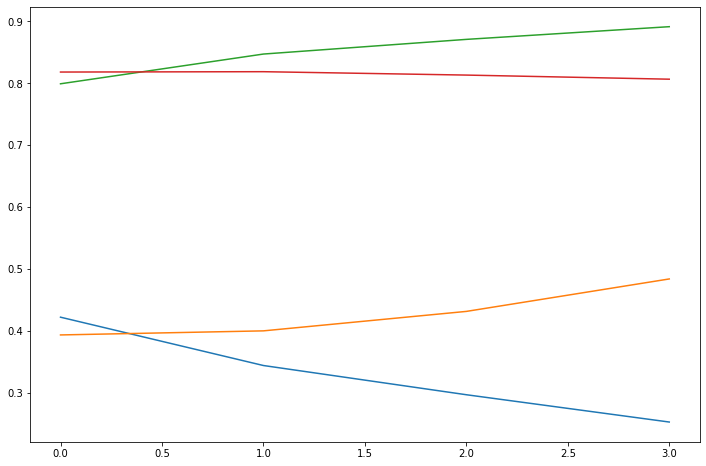

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [14]:
# 후기 데이터 불러오기
import pymysql
conn = pymysql.connect(host='localhost', user='root', password='root', db='collection', charset='utf8mb4')
cur = conn.cursor()
cur.execute('select review from 29cm_lumir_review')
data = cur.fetchall()
cur.close()
conn.close()

In [15]:
data = list(data)

In [16]:
review = [row[0] for row in data]

In [17]:
review

['색감도 좋고 밝기 및 색상 조절이 되서 좋네요. 견고한 부분이 있고 높이도 좋습니다. 밤에 켜두기 좋네요.',
 '약간 기우뚱? 하는데 제가 잘못 나사를 돌림거 같구 예뻐요~~~ 식탁위에 놓으려고 샀어요 !!!잘 쓸게여',
 '무야~호~~~ 예뻐요!!! 밝기조절, 취침 타이머가 있어 느므 좋습니다. 유광이라 고급짐이 있어요ㅎ 방이 한층더 예뻐졌어요',
 '남자친구 선물이었는데 정말 대만족이에요! 생각보다 큰 것 같았는데 설치하고나니 마음에 딱 들고 유광하길 잘한거 같아요 ㅎㅎ 빛 조절이 되어서 좋습니다',
 '저희집에 찰떡이네요! 여기저기 어디에 둬도 잘 어울려요!! 다만 엄청 무거워서 조심해야 할듯 해요',
 '제품은 예쁘지만..\n벌트부터 기울어져서 설치했을때\n아무리해도 각도가 기울어져요\n제가 받은 제품만 그런걸까요?ㅡㅡ',
 '생각보다 크긴 했지만 빛이 은은한데다 색온도와 밝기조절, 타이머 기능까지 있어서 매우 요긴하게 잘 쓰고 있어요.\n장스탠드를 사려다가 공간이 애매해 이 제품을 대신 산건데 빛이 그만큼 밝아서 좋습니다.\n레스토랑도 마음대로 가지 못하는 요즘에 분위기 내는데 딱 좋아요 :)\n\n대신 유리갓의 수평이 딱 떨어지게 맞진 않는 것 같고, 갓 군데군데 약간의 흠이 보이긴 하지만 아직 사용하는데 무리는 없습니다.\n디자인, 기능이 값어치만큼은 하는 것 같아요.',
 '생각보다 크긴한데 조명색도 조절되고 단계도 조절되서 넘 좋아요',
 '더많이 밝았으면 좋겠지만 은은하니 괜찮아요 눈이 편안해집니다 \n디자인도 넘 깔끔하니 맘에 들어요! 할인할때 잘샀습니다.',
 '처음에 제품 받고 기울어서 문의드렸는데, 답변 링크 받고 각도 조절 했습니다. 그렇지만 잘 조립해보아도 여전히 약간의 기울임은 있고, 헤드 나사가 딱 맞지 않고 뜨는건 거슬리긴 합니다.\n쉐이드랑 상단 부품 곳곳에 스크래치도 있으나 크게 보이는 부분은 아니라 신경쓰지 않고 쓰려 합니다.\n심플한 디자인과 전구가 아닌 led이고, 조명색, 밝기 조절 가능한 점은 맘에 듭니다. 

In [18]:
def preprocessing(txt):
    import re
    txt = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', txt)
    sw = set() # 집합자료형 선언
    with open('stopwords-ko.txt', encoding='utf-8') as f:
        for w in f:
            sw.add(w.replace('\n',''))
    doc = []
    from eunjeon import Mecab
    mecab = Mecab()
    for word in mecab.morphs(txt):
        if word not in sw and len(word) > 1:
            doc.append(word)
    return doc

In [19]:
def predict_func(review,pre_data):
    for text in review:
        text = preprocessing(text)
        text = tokenizer.texts_to_sequences([text])
        text = pad_sequences(text, maxlen=max_len, padding='pre')
        pre_data.append((model.predict(text)))
    return pre_data
        

In [20]:
pre_data = []
out_data = predict_func(review,pre_data)

In [25]:
out_data

[array([[0.8772398]], dtype=float32),
 array([[0.08034244]], dtype=float32),
 array([[0.99951833]], dtype=float32),
 array([[0.99675393]], dtype=float32),
 array([[0.9013386]], dtype=float32),
 array([[0.00234681]], dtype=float32),
 array([[0.00617227]], dtype=float32),
 array([[0.37066394]], dtype=float32),
 array([[0.99860895]], dtype=float32),
 array([[0.01357305]], dtype=float32),
 array([[0.69846195]], dtype=float32),
 array([[0.60324705]], dtype=float32),
 array([[0.07206702]], dtype=float32),
 array([[0.8494116]], dtype=float32),
 array([[0.90818727]], dtype=float32),
 array([[0.9992472]], dtype=float32),
 array([[0.9965526]], dtype=float32),
 array([[0.04986346]], dtype=float32),
 array([[0.981714]], dtype=float32),
 array([[0.89949834]], dtype=float32),
 array([[0.9988506]], dtype=float32),
 array([[0.0037328]], dtype=float32),
 array([[0.99906]], dtype=float32),
 array([[0.99970853]], dtype=float32),
 array([[0.29943174]], dtype=float32),
 array([[0.99519205]], dtype=float32)